# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, I'm going to use tensorflow to train a CNN to recognize German traffic sign data.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.

---
## Step 0: Load The Data
The pickled data is a dictionary with 4 key/value pairs:
- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [1]:
### Import all the libraries used in this notebook
import pickle
import sys
import os
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import random
from collections import Counter
from tensorflow.contrib.layers import flatten



In [2]:
# Load data in pickle form

# import pickle
training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train,size_train, coords_train = train['features'], train['labels'],train['sizes'], train['coords']
X_test, y_test,size_test, coords_test = test['features'], test['labels'],test['sizes'], test['coords']

Notes:
Pickle protocol is basically the file format. From the documentation, The higher the protocol used, the 
 more recent the version of Python needed to read the pickle produced. ... Pickle protocol version 4 was 
 added in Python 3.4, your python version (2.7.5) does not support this.
 Either upgrade to Python 3.4 or later (current is 3.5) or create the pickle using a lower protocol (2) 
 in the third parameter to pickle.dump()

### Self defined functions
Put all the customized function in the beginning of the notebook. Some debugging codes will appear in a sequence

In [3]:
### Convert color image to different forms
def image_tranformation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # normalize = cv2.normalize(gray)

    fig = plt.figure()
    fig.set_size_inches(5, 6)
    a=fig.add_subplot(2,2,1)
    imgplot = plt.imshow(img)
    a.set_title('Original image')


    a=fig.add_subplot(2,2,2)
    imgplot = plt.imshow(gray, cmap='gray')
    a.set_title('Convert to gray')


    equalize = cv2.equalizeHist(gray)
    a=fig.add_subplot(2,2,3)
    imgplot = plt.imshow(equalize, cmap='gray')
    a.set_title('Apply equalizer on gray')


    # create a CLAHE object (Arguments are optional).(Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray)

    a=fig.add_subplot(2,2,4)
    imgplot = plt.imshow(cl1, cmap='gray')
    a.set_title('Apply CLAHE on gray')

    print('The class of this image is:',sign_dict[str(y_train[index])])


### Display first 5 images in the sequence(for debug use)
def display(images):
    for img in images:
        plt.figure()
        plt.imshow(img)

---

## Step 1: Dataset Summary & Exploration
Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[1].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.


In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
    
# Visualizations will be shown in the notebook.
%matplotlib inline

# Load the data dictionary for classes
signnames = csv.reader(open('signnames.csv', 'r'))

sign_dict = {}
for row in signnames:
   index, label = row
   sign_dict[index] = label

# print(sign_dict)


The class of 18519th image is: Priority road


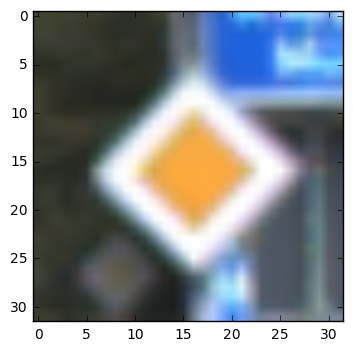

In [6]:
# 1. plot the n-th traffic sign image in train set, with it's label, find the bounding box around the sign in the 
# image
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.imshow(image)
print('The class of {}th image is:'.format(index),sign_dict[str(y_train[index])])

The class of this image is: Priority road


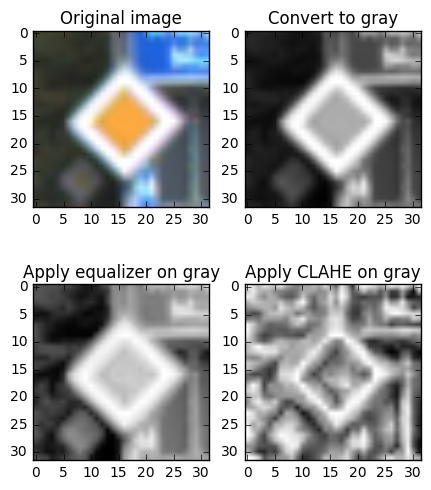

In [7]:
# 2. plot grayscale
image_tranformation(X_train[index])

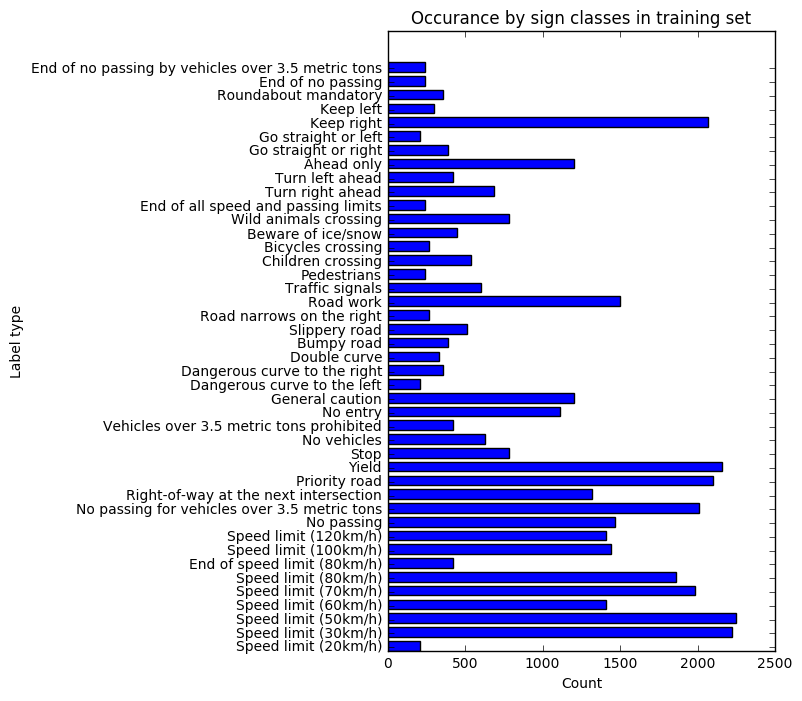

In [8]:
# 2. plot each type traffic sign count in training set(histogram)

#from collections import Counter
counts = Counter(y_train)
label_indexes = counts.keys()
label_names = [sign_dict[str(i)] for i in label_indexes]
label_counts = counts.values()

indexes = np.arange(len(label_names))

fig = plt.gcf()
fig.set_size_inches(5, 8)

plt.barh(indexes, label_counts, height = 0.7)
plt.yticks(indexes + 0.25, label_names)
plt.xlabel('Count')
plt.ylabel('Label type')
plt.title('Occurance by sign classes in training set')

# plt.savefig('SignOccurance.png', 
#             dpi= 100, # The resolution in dots per inch.
#             facecolor='w', edgecolor='w', #the colors of the figure rectangle
#             format = 'png', # One of the file extensions supported by the active backend. png, pdf, ps, eps and svg.
#             transparent=False, bbox_inches=None, pad_inches=0.1,
#             frameon=None)

plt.show()

According to the plot, even the least frequent class has more than 200 occurance, I think this is a good dataset. However we will keep this in mind and after running the model. It's important to see how each type of the traffic sign are labeled. And possible if some minor class are low, I will use some augmentation method to increase the training size(in automated way)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

## Pre-process the Data Set (normalization, grayscale, etc.)

### Workflow:
1. Trim image to keep only traffic sign region  
By performing this I can get the most cleaned traffic sign feature. This step increase the accuarcy a lot.
2. Resize image to (32,32,n)  
Make all the images in the same scale. 
3. Convert image to gray  
I observed a few images having very different color schema. So although in reality color is an important feature, it might be affected by the time the image was taken. Plus after converting imge to gray, it increase the computation speed.
4. Scale image to be 0 mean
This has the effect of zero-centering the data, and making the data fall within the range -1 to 1
Standardizing the pixel values helps gradient descent converge faster
Justification for zero-centering the data can be found at: https://youtu.be/GUtlrDbHhJM?t=19m
Dividing the pixel values by 128 is not strictly necessary for this project, because all original pixel values are on the same scale, from 0 to 255. However, this division step is computationally cheap, and it's good practice in the long term to standardize the image preprocessing requirements, over many different projects with potentially different image representations. Over the course of many projects in the future, abiding by this practice can help reduce confusion and potential frustration.

In [9]:
### Step1: Extract the region contains traffic sign, and resize the image to 32 by 32
def trim_resize_image(img,size,coords):
    coord = coords.reshape(2,2)
    resize = size/img.shape[0:2]
    resize_coords = coord/resize
    resize_coords_int = resize_coords.astype(int)
    trim_img = img[resize_coords_int[0,0]:resize_coords_int[1,0]+2,resize_coords_int[0,1]:resize_coords_int[1,1]+2]
    return trim_img

### Step 4: Scale the image in the range of [-1,1]
def scale_image(img, a=-1,b=1):
    max_scale = 255
    min_scale = 0
    return a+(img/max_scale-min_scale)/(b-a)

### Step 2-4:
def image_process(trim_img, a=-1,b=1):
    img_32by32 = cv2.resize(trim_img,(32,32), interpolation = cv2.INTER_CUBIC)
    img_gray = cv2.cvtColor(img_32by32, cv2.COLOR_RGB2GRAY)
    img_scale = scale_image(img_gray.reshape(32,32,1), a,b)
    return img_scale

image_process(X_train[1]).shape

(32, 32, 1)

In [10]:
## Update the trim_resize_image function before apply on test images. Due to errors in original size, for example test
# image 2847. See debuging notes below.

def trim_resize_image(img,size,coords):
    coord = coords.reshape(2,2)
    resize = size/img.shape[0:2]
    resize_coords = coord/resize
    resize_coords_int = resize_coords.astype(int)
    trim_img = img[resize_coords_int[0,0]:resize_coords_int[1,0]+2,resize_coords_int[0,1]:resize_coords_int[1,1]+2]
    # Adding Error handling capability for strange size images
    try:
        resize_img =  cv2.resize(trim_img,(32,32), interpolation = cv2.INTER_CUBIC)
        #break
    except (cv2.error): #Opencv has its own error. If anything wrong, return the original image
        resize_img = img
    return resize_img



### Debug code here
# Error: .... error: (-215) ssize.area() > 0 in function resize
# Seems like some image could not be resize. So I ran for loop to resize all images and print its index. The error 
# occurs at 2847 for the first time

# i= 2800 
# for img, size, coords in zip(X_test[2800:], size_test[2800:], coords_test[2800:]):
#     print(i)
#     trim_resize_image(img, size, coords)
#     i=i+1

# error_i = 2847
# img = X_test[error_i] 
# size = size_test[error_i] # original size is 2,229. Very strange size. Not feasible to cut and resize. So just ignore
# coord = coords_test[error_i]



In [11]:
# Process training images
train_imgs_trim = [trim_resize_image(img, size, coords) for img, size, coords in zip(X_train, size_train, coords_train)]
train_images = [image_process(img) for img in train_imgs_trim]

# Process test images
test_imgs_trim = [trim_resize_image(img, size, coords) for img, size, coords in zip(X_test, size_test, coords_test)]
test_images = [image_process(img) for img in test_imgs_trim]

### Split Data into Training, Validation and Testing Sets

In [12]:
### Split the data into training/validation sets here.

from sklearn.utils import shuffle

# Split the data for 70% training, 30% validation
train_index = int(0.7*len(X_train))

# print(train_index)
X_train_s, y_train_s = shuffle(train_images, y_train)
x_training, x_validation = X_train_s[:train_index], X_train_s[train_index:]
y_training, y_validation = y_train_s[:train_index], y_train_s[train_index:]



### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

def LeNet_Changed(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    
    #Dropout
    fc1 = tf.nn.dropout(fc1,keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 200. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    #Dropout
    fc2 = tf.nn.dropout(fc2,keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [14]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [15]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
# x = tf.placeholder(tf.float32, (None, 32, 32))

y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

keep_prob = tf.placeholder(tf.float32)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

In [16]:
rate = 0.001

#logits = LeNet_Default(x)
logits = LeNet_Changed(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [18]:
EPOCHS = 15
BATCH_SIZE = 128
import time

with tf.Session() as sess:
    # Run Inference
    t = time.time()
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_training)
    training_accuracy_list = []
    validation_accuracy_list = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_training, y_training = shuffle(x_training, y_training)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_training[offset:end], y_training[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.8})
        
        training_accuracy = evaluate(x_training, y_training)
        validation_accuracy = evaluate(x_validation, y_validation)
        training_accuracy_list.append(training_accuracy)
        validation_accuracy_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time: %.3f seconds" % (time.time() - t))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.378
Validation Accuracy = 0.385
Time: 35.473 seconds

EPOCH 2 ...
Training Accuracy = 0.725
Validation Accuracy = 0.723
Time: 68.584 seconds

EPOCH 3 ...
Training Accuracy = 0.827
Validation Accuracy = 0.821
Time: 101.889 seconds

EPOCH 4 ...
Training Accuracy = 0.877
Validation Accuracy = 0.871
Time: 134.700 seconds

EPOCH 5 ...
Training Accuracy = 0.903
Validation Accuracy = 0.895
Time: 167.047 seconds

EPOCH 6 ...
Training Accuracy = 0.919
Validation Accuracy = 0.913
Time: 199.461 seconds

EPOCH 7 ...
Training Accuracy = 0.934
Validation Accuracy = 0.926
Time: 232.653 seconds

EPOCH 8 ...
Training Accuracy = 0.949
Validation Accuracy = 0.942
Time: 266.624 seconds

EPOCH 9 ...
Training Accuracy = 0.953
Validation Accuracy = 0.945
Time: 299.433 seconds

EPOCH 10 ...
Training Accuracy = 0.963
Validation Accuracy = 0.954
Time: 334.803 seconds

EPOCH 11 ...
Training Accuracy = 0.963
Validation Accuracy = 0.954
Time: 370.423 seconds

EPOCH 12

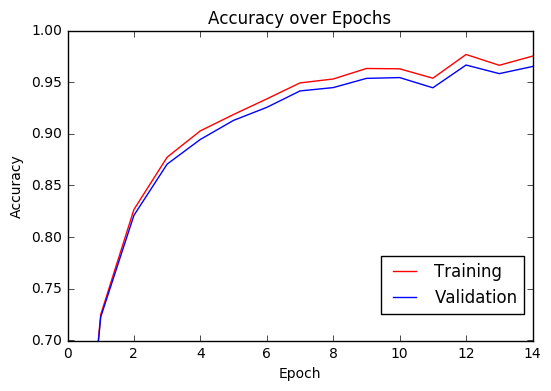

In [19]:
# Analyze the model --> plot training and validation set accuarcy. See if at some point the validation accuarcy 
# decrease --> Overfit, should reduce the number of EPOCHS 

plt.plot(range(EPOCHS), training_accuracy_list,'r-', label="Training")
plt.plot(range(EPOCHS), validation_accuracy_list,'b-', label="Validation")
#plt.xlim(0,EPOCHS)
plt.ylim(0.7,1)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1, 0.3))
plt.title('Accuracy over Epochs')
plt.show()


# Use EPOCHS = 20 and create the same plot
# plt.savefig('Overfitting.png', 
#             dpi= 100, # The resolution in dots per inch.
#             facecolor='w', edgecolor='w', #the colors of the figure rectangle
#             format = 'png', # One of the file extensions supported by the active backend. png, pdf, ps, eps and svg.
#             transparent=False, bbox_inches=None, pad_inches=0.1,
#             frameon=None)

### Check overfitting issue
I ran for 20 Epochs, and save the file locally.
![Image](./Images/Overfitting.png)


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

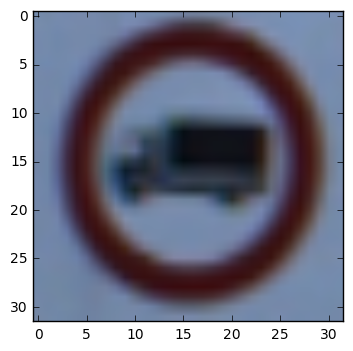

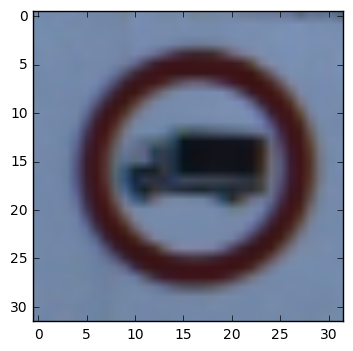

In [20]:
img00 = trim_resize_image(X_test[0], size_test[0], coords_test[0])
plt.imshow(img00)
plt.figure()
plt.imshow(X_test[0])

In [21]:
# Test on test.p

#X_test, y_test,size_test, coords_test

### Call function trim_imgs(defined above in section "Self defined functions"), cut the image to be in coords and
# Resize it to 32 by 32

trim_imgs_test = [trim_resize_image(img, size, coords) for img, size, coords in zip(X_test, size_test, coords_test)]
X_gray_test = [cv2.cvtColor(i, cv2.COLOR_RGB2GRAY).reshape((32,32,1)) for i in trim_imgs_test]
scale_test = [scale_image(img) for img in X_gray_test]

In [22]:
# new_saver = tf.train.import_meta_graph('lenet.meta')
# new_saver.restore(sess, tf.train.latest_checkpoint('./'))
#training_accuracy = evaluate(X_gray_test, y_test)
with tf.Session() as sess:

    #saver.restore(sess,save_file)
    print('Loading stored session...')
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    validation_accuracy = evaluate(scale_test, y_test)
    print("Test Accuracy = {:.3f}".format(validation_accuracy))

#test_accuracy_new = sess.run(accuracy_operation, feed_dict={x: X_gray_test, y:  y_test})
#print(test_accuracy_new)

# 3 Epochs acc is 0.872526 
# 20 epochs using default lenet is 0.905463
# 10 epochs using modified lenet is 0.935
# 15 epochs using modified lenet is 0.917

Loading stored session...
Test Accuracy = 0.908


In [23]:
with tf.Session() as sess:

    #saver.restore(sess,save_file)
    print('Loading stored session...')
    new_saver = tf.train.import_meta_graph('lenet.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    pred = tf.argmax(logits, 1)
    prediction = sess.run(pred, feed_dict={x: scale_test, y: y_test, keep_prob:1})

Loading stored session...


### Confusion matrix

Show first 5 classes performance scores:
   precision    recall  fbeta_score  support
0   0.758621  0.733333     0.745763     60.0
1   0.941015  0.952778     0.946860    720.0
2   0.893827  0.965333     0.928205    750.0
3   0.851153  0.902222     0.875944    450.0
4   0.945372  0.943939     0.944655    660.0


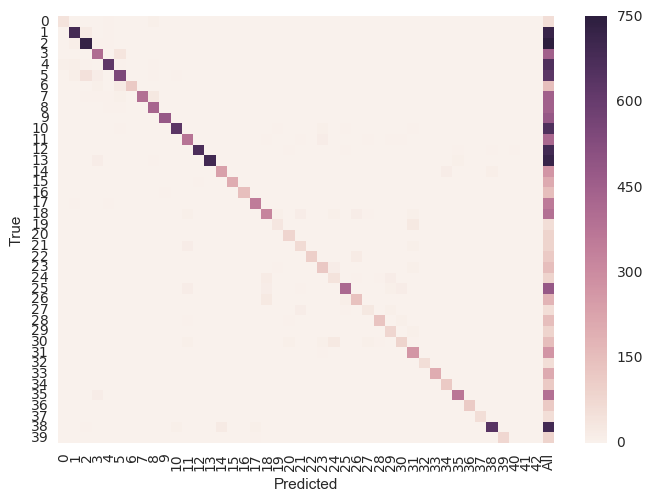

In [24]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support as score
import seaborn as sns


confusion_table = pd.crosstab(y_test , prediction, rownames=['True'], colnames=['Predicted'], margins=True)
#print(confusion_table[0:41][0:42])

# Plot heat map for the confusion matrix
sns.heatmap(confusion_table[0:40][0:40])


evaluation = score(y_true =y_test, y_pred =prediction, labels = range(43))
evaluation2  = pd.DataFrame(np.transpose(evaluation), columns=['precision','recall', 'fbeta_score', 'support'])
print('Show first 5 classes performance scores:')
print(evaluation2[:][0:5])

In [25]:
confusion_table

Predicted,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,All
True,,,,,,,,,,,,,,,,,,,,,
0,44,1,0,0,5,0,0,0,8,0,...,0,0,0,0,0,0,0,0,0,60
1,2,686,23,0,3,1,0,1,1,0,...,0,0,0,0,1,0,0,0,0,720
2,0,9,724,5,4,2,0,2,0,0,...,0,0,0,0,0,0,0,0,0,750
3,0,1,2,406,0,37,0,0,1,0,...,0,1,0,0,0,0,0,0,0,450
4,8,9,5,2,623,4,0,0,3,0,...,0,0,1,0,0,0,0,0,0,660
5,1,10,49,14,2,545,1,1,3,1,...,0,0,0,0,0,0,0,0,0,630
6,0,0,0,8,0,22,116,0,0,0,...,0,0,0,0,2,0,0,0,0,150
7,0,2,3,5,4,6,0,394,31,0,...,0,0,0,0,0,0,0,0,0,450
8,0,1,0,2,5,3,0,1,431,1,...,0,1,0,0,2,0,0,0,0,450


In [26]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Steps: download a few images from http://benchmark.ini.rub.de/?section=gtsrb&subsection=news. Store it in a 
### folder './OnlineTestData/'.Rename the images according to signnames.csv
from os import listdir
from os.path import isfile, join


test_path = './OnlineTestData/'

onlyfiles = [ f for f in listdir(test_path) if isfile(join(test_path,f)) ]
#test_img = np.empty(len(onlyfiles), dtype=object)
test_img = []
test_label=[]
for n in range(1, len(onlyfiles)):
    img = cv2.imread(join(test_path,onlyfiles[n]))
    # Get the file name without extension, convert to integer
    clas = int(os.path.splitext(onlyfiles[n])[0])
    test_label.append(clas)
    # Resize the image to be 32*32*3
    resize = cv2.resize(img, (32,32)) 
    test_img.append(cv2.cvtColor(resize, cv2.COLOR_RGB2GRAY).reshape((32,32,1)))

    
scale_test_2 = [scale_image(img) for img in test_img]    
test_label = np.array(test_label,dtype = int)

### Predict the Sign Type for Each Image

In [27]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

sess = tf.Session()
new_saver = tf.train.import_meta_graph('lenet.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
test_accuracy = sess.run(accuracy_operation, feed_dict={x: scale_test_2, y: test_label, keep_prob:1})

### Analyze Performance

In [28]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
print("Test Accuracy = {0:.0f}%".format(test_accuracy*100))

Test Accuracy = 100%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [29]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
softmax = tf.nn.softmax(logits, dim=-1, name=None)
top_k_pred = tf.nn.top_k(softmax, k=5, name=None)
#in_top5 = tf.nn.in_top_k(softmax,y, k=1,  name=None)

sess = tf.Session()
new_saver = tf.train.import_meta_graph('lenet.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))
#in_top5_pred = sess.run(in_top5, feed_dict={x: test_img, y: test_label})
top5_pred = sess.run(top_k_pred, feed_dict={x: scale_test_2, keep_prob:1 })

print(top5_pred)

TopKV2(values=array([[  9.99999881e-01,   5.66648595e-08,   5.62474867e-08,
          1.02970441e-08,   1.73644332e-09],
       [  9.99911189e-01,   3.76307144e-05,   2.97298757e-05,
          1.11658665e-05,   6.91291416e-06],
       [  9.99863744e-01,   1.33458831e-04,   1.31146999e-06,
          6.40240444e-07,   3.28719068e-07],
       [  1.00000000e+00,   2.31554509e-08,   8.14229306e-09,
          1.25385191e-09,   1.86078861e-11],
       [  9.99313712e-01,   4.08323045e-04,   1.42166624e-04,
          1.21402249e-04,   6.52129165e-06]], dtype=float32), indices=array([[13, 14, 12,  2, 40],
       [14, 33, 17, 13, 25],
       [34, 38, 20, 35, 13],
       [35,  3,  5, 34, 36],
       [ 4,  1,  0,  8,  5]], dtype=int32))


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 